# **Predicting Hotel Booking Cancellations Using Machine Learning**

**Project Overview**:

Hotel booking cancellations have become a crucial problem for the hospitality industry, leading to significant revenue loss and operational inefficiencies. In this context, inventory refers to hotel rooms, and the inability to sell a room due to last-minute cancellations results in inventory loss. This project aims to develop a machine learning solution to predict the likelihood of booking cancellations for **INN Hotels Group**, enabling proactive measures to mitigate potential losses.

By accurately predicting potential cancellations, **INN Hotels Group** can implement strategies to minimize these negative impacts and optimize their revenue management practices.

**Problem Definition**

| Current State | Gap | Target |
|---------------|-----|--------|
| 1. Inventory loss due to cancellations has risen to an all-time high of 18% | No predictive mechanism for cancellations | Develop a machine learning model using historical booking data to forecast cancellation probabilities |
| 2. Revenue loss has reached approximately \$0.25 million annually | Lack of proactive measures to mitigate cancellations  | 1. Implement dynamic pricing strategies based on cancellation predictions<br>2. Develop targeted retention campaigns for high-risk bookings<br>3. Optimize overbooking policies using cancellation forecasts |




**Objective**: 

Develop a predictive model to forecast the probability of hotel booking cancellations for **INN Hotels Group**, enabling proactive measures to mitigate revenue loss from unfilled rooms.

---

In [1]:
# For reading and manipulating data
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing
from sklearn.preprocessing import LabelEncoder

# To split data
from sklearn.model_selection import train_test_split

# To build ML model
from sklearn.tree import DecisionTreeClassifier

# To tune ML model
from sklearn.model_selection import GridSearchCV

# To evaluate the ML model
from sklearn.metrics import (
    f1_score,
    make_scorer,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the data into a Pandas dataframe
hotel = pd.read_csv("../data/INNHotelsGroup.csv")

In [3]:
# Overview of the dataset
hotel.head(10)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,224,Offline,0,65.00,2,1,2017-10-02,0,2,Not_Canceled
1,5,Online,1,106.68,2,2,2018-11-06,0,3,Not_Canceled
2,1,Online,0,60.00,1,2,2018-02-28,0,1,Canceled
3,211,Online,0,100.00,2,0,2018-05-20,0,2,Canceled
4,48,Online,0,94.50,2,1,2018-04-11,0,1,Canceled
5,346,Online,1,115.00,2,0,2018-09-13,0,2,Canceled
6,34,Online,1,107.55,2,1,2017-10-15,0,3,Not_Canceled
7,83,Online,1,105.61,2,1,2018-12-26,0,3,Not_Canceled
8,121,Offline,1,96.90,3,0,2018-07-06,0,4,Not_Canceled
9,44,Online,3,133.44,2,0,2018-10-18,0,5,Not_Canceled


In [4]:
hotel['booking_status'].value_counts()

booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64

We have **class imbalance** in our dataset. For our model evaluation we will consider metrics that are more informative in such scenarios. The common metrics used for imbalanced classification problems include:

- **Confusion Matrix**: This provides a detailed breakdown of the true positives, true negatives, false positives, and false negatives. It’s a good starting point for understanding the classification performance.
- **F1-Score**: The harmonic mean of precision and recall, providing a single metric to evaluate the balance between them.


## **Model Building**

### **Data Preprocessing**


In [5]:
# Copy of the data
data = hotel.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lead_time                   36275 non-null  int64  
 1   market_segment_type         36275 non-null  object 
 2   no_of_special_requests      36275 non-null  int64  
 3   avg_price_per_room          36275 non-null  float64
 4   no_of_adults                36275 non-null  int64  
 5   no_of_weekend_nights        36275 non-null  int64  
 6   arrival_date                36275 non-null  object 
 7   required_car_parking_space  36275 non-null  int64  
 8   no_of_week_nights           36275 non-null  int64  
 9   booking_status              36275 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 2.8+ MB


---

We do the following:
- Encode the categorical variables using numerical values.
- Convert arrival date to datetime datatype to extract more features.

In [7]:
# Encoding the target (booking_status) attribute
data["booking_status"] = data["booking_status"].apply(
    lambda x: 1 if x == "Canceled" else 0
)

In [8]:
# Encode categorical columns
categorical_columns = ['market_segment_type']
le = LabelEncoder()
# Apply LabelEncoder to the categorical column
data[categorical_columns] = data[categorical_columns].apply(le.fit_transform)

In [10]:
# Convert the 'arrival_date' column to datetime type
data['arrival_date'] = pd.to_datetime(data['arrival_date'])

# Extracting month from 'arrival_date'
data['arrival_month'] = data['arrival_date'].dt.month

In [11]:
data.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,arrival_month
0,224,0,0,65.00,2,1,2017-10-02,0,2,0,10
1,5,1,1,106.68,2,2,2018-11-06,0,3,0,11
2,1,1,0,60.00,1,2,2018-02-28,0,1,1,2
3,211,1,0,100.00,2,0,2018-05-20,0,2,1,5
4,48,1,0,94.50,2,1,2018-04-11,0,1,1,4


### **Model Training**

In [12]:
# Seperate the features and target variable
X = data.drop(["booking_status","arrival_date"], axis=1)
y = data["booking_status"]

In [13]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [14]:
X.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_month
0,224,0,0,65.00,2,1,0,2,10
1,5,1,1,106.68,2,2,0,3,11
2,1,1,0,60.00,1,2,0,1,2
3,211,1,0,100.00,2,0,0,2,5
4,48,1,0,94.50,2,1,0,1,4


In [15]:
# Define the ML model to build
model = DecisionTreeClassifier(random_state=1)

# Train the ML model on the train data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

#### Model Evaluation on the training set

In [16]:
# Make predictions on the training set
y_train_pred = model.predict(X_train)

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

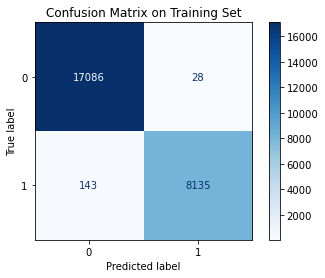

In [18]:
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Training Set')
plt.show()

In [19]:
model_train_score = f1_score(y_train, y_train_pred)

print("Model score on the training dataset is", np.round(100*model_train_score, 2))

Model score on the training dataset is 98.96


#### Model Evaluation on the test set

In [20]:
# Make predictions on the training set
y_test_pred = model.predict(X_test)

In [21]:
# Compute the confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

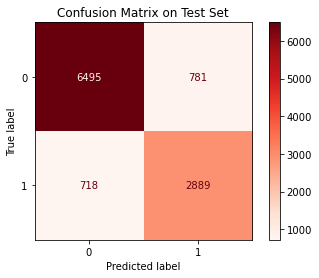

In [22]:
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix on Test Set')
plt.show()

In [23]:
model_test_score = f1_score(y_test, y_test_pred)

print("Model score on the test dataset is", np.round(100*model_test_score, 2))

Model score on the test dataset is 79.4


- The large discrepancy between the model's performance on the training dataset (98.72%) and the test dataset (77.93%) suggests that your model may be experiencing **overfitting**.

---

### **Hyperparameter Tuning**

We will use **Grid Search** to find the best hyperparameters for our model.

In [24]:
dummy_model = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Define the parameter grid for DecisionTreeClassifier
param_grid = {
    'max_depth': [None, 10, 20, 30],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    "max_leaf_nodes": [150, 250],
    'criterion': ['gini', 'entropy']           # Function to measure the quality of a split
}

# Define the model score on which we want to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the model tuning algorithm
grid_obj = GridSearchCV(estimator=dummy_model, param_grid=param_grid, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

In [25]:
# selecting the best combination of parameters for the model to create a new model
tuned_model = grid_obj.best_estimator_

# training the new ML Model
tuned_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=250,
                       min_samples_leaf=2, random_state=1)

In [26]:
# evaluating the model performance on the train data
tuned_model_train_predictions = tuned_model.predict(X_train)
tuned_model_train_score = f1_score(y_train, tuned_model_train_predictions)

print("Model Score on Train Data:", np.round(100*tuned_model_train_score, 2))

Model Score on Train Data: 81.83


In [27]:
# evaluating the model performance on the test data
tuned_model_test_predictions = tuned_model.predict(X_test)
tuned_model_test_score = f1_score(y_test, tuned_model_test_predictions)

print("Model Score on Test Data:", np.round(100*tuned_model_test_score, 2))

Model Score on Test Data: 80.22


In [28]:
final_model = tuned_model

In [29]:
# evaluating the model performance on the test data
final_model_test_predictions = final_model.predict(X_test)
final_model_test_score = f1_score(y_test, final_model_test_predictions)

print("Model Score on Test Data:", np.round(100*final_model_test_score, 2))

Model Score on Test Data: 80.22


In [30]:
# To deploy the ML model
import joblib

In [31]:
# Export the final model to the disk
joblib.dump(final_model, '../models/hotel_cancellation_prediction_model_v1_0.joblib')

['../models/hotel_cancellation_prediction_model_v1_0.joblib']